In [ ]:
import os
import numpy as np
import pandas as pd
import random
import cv2
import keras
import seaborn as sns
from PIL import Image
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sns
import argparse
import imutils
import tensorflow as tf
import pandas.util.testing as tm
%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator

from keras.layers import Dense, GlobalAveragePooling2D, Input, Flatten, Dropout, BatchNormalization
from keras.models import Model, Sequential
from keras import backend as K
from keras.applications.densenet import DenseNet121
from keras.applications.imagenet_utils import preprocess_input
import keras.utils as image
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

#from tensorflow.keras.utils import load_img,img_to_array #,ImageDataGenerator
#from tensorflow.keras.preprocessing import image


<ipython-input-1-b03dc94e7ab0>:17: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
train_data_path = '/content/drive/MyDrive/chest_xray/train'
test_data_path = '/content/drive/MyDrive/chest_xray/test'


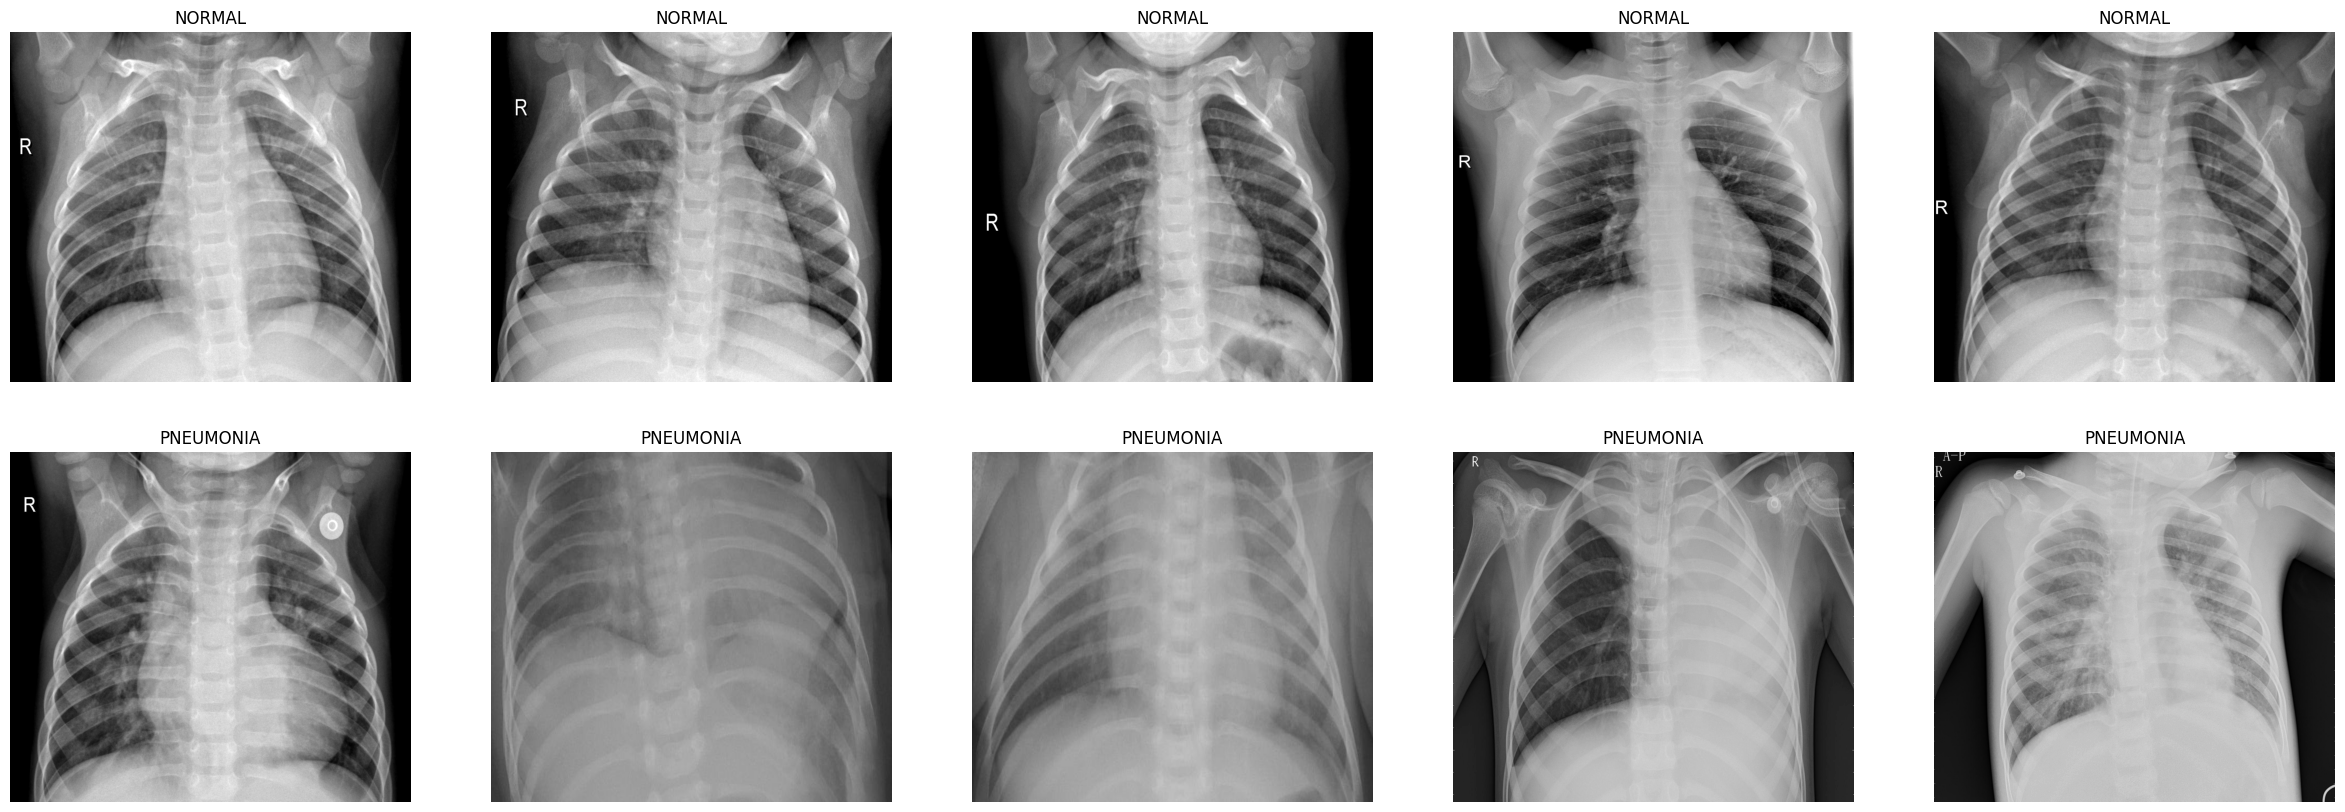

In [ ]:
# Get few samples for both the classes
bacteria_cases_dir = os.path.join(train_data_path,'NORMAL')
virus_cases_dir = os.path.join(train_data_path,'PNEUMONIA')

# Get the list of all the images
bacteria_cases = glob(bacteria_cases_dir + '/*.jpeg')
virus_cases = glob(virus_cases_dir + '/*.jpeg')

# An empty list
samples = []

# Go through all the normal cases. The label for these cases will be 0
for i in range(5):
    samples.append(bacteria_cases[i])

# Go through all the pneumonia cases. The label for these cases will be 1
for i in range(5):
    samples.append(virus_cases[i])

# Plot the data
f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("NORMAL")
    else:
        ax[i//5, i%5].set_title("PNEUMONIA")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()


In [ ]:
# Data generation objects
train_datagen = ImageDataGenerator(zoom_range=0.1,
                                   horizontal_flip = True,
                                   fill_mode = 'constant',
                                   validation_split=0.1,
                                   preprocessing_function = preprocess_input)

test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

image_size = 224
batch_size = 32

# This is fed to the network in the specified batch sizes and image dimensions
train_gen = train_datagen.flow_from_directory(train_data_path,
                                              target_size=(image_size, image_size),
                                              batch_size=batch_size,
                                              class_mode='binary',
                                              shuffle=True,
                                              subset='training')

val_gen = train_datagen.flow_from_directory(train_data_path, # same directory as training data
                                                  target_size=(image_size, image_size),
                                                  batch_size=batch_size,
                                                  shuffle = True,
                                                  class_mode='binary',
                                                  subset='validation')

test_gen = test_datagen.flow_from_directory(test_data_path,
                                                target_size=(image_size, image_size),
                                                batch_size=batch_size,
                                                class_mode='binary',
                                                shuffle=True)



Found 4695 images belonging to 2 classes.
Found 521 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Handling Class Imbalance using Weighted Loss Function

In [ ]:
#Compute class weights for handling the imbalance in data

bacteria_pneumonia_dir = os.path.join(train_data_path, 'NORMAL')
virus_pneumonia_dir = os.path.join(train_data_path, 'PNEUMONIA')

bacteria_cases = glob(bacteria_pneumonia_dir + '/*.jpeg')
virus_cases = glob(virus_pneumonia_dir + '/*.jpeg')

train_labels = []

for img_path in bacteria_cases:
  train_labels.append(0)

for img_path in virus_cases:
  train_labels.append(1)

#convert label list to numpy array
train_labels = np.array(train_labels)

#Compute class weights for each class
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes=np.unique(train_labels),
                                                 y=train_labels)
print(class_weights)


[1.9448173  0.67303226]


Transfer Learning

In [ ]:
# create the base pre-trained model
base_model = DenseNet121(weights='imagenet', include_top=False)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

#Dropout Layer
x = Dropout(0.2)(x) # Regularize with dropout

# and a logistic layer
predictions = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)



29084464/29084464 [==============================] - 0s 0us/step


Freeze the convolutional base

In [ ]:
# don't train existing weights
for layer in base_model.layers:
  layer.trainable = False

#Check the model summary and trainable parameters
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1/conv (Conv2D)            (None, None, None,   9408        ['zero_padding2d[0][0]']         
                                64)                                                           

Optimizer

In [ ]:
#Follow ChexNeXt Paper
base_learning_rate = 0.0001

#Compile model
model.compile(optimizer=Adam(lr= base_learning_rate), loss= "binary_crossentropy", metrics = ['accuracy'])



/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
#epochs
initial_epochs = 8

# Callbacks
#Save best model
ckpt_filename= "/content/drive/My Drive/DATASET/chest_xray/dn121_class_weights_pretrained.hdf5"
checkpoint = ModelCheckpoint(filepath=ckpt_filename, save_best_only=True, save_weights_only=True, verbose = 1)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, mode='min', verbose = 1)


Assign the class weights

In [ ]:
# Fitting the model
from tensorflow.keras.preprocessing import image
history = model.fit(train_gen,
                    epochs=initial_epochs,
                    validation_data=val_gen,
                    callbacks=[checkpoint, early_stop, lr_reduce],
                    class_weight = {0: class_weights[0], 1: class_weights[1]})
'''
step_size_train = train_generator.n//train_generator.batch_size
step_size_val = validation_generator.n//validation_generator.batch_size
history = model.fit(train_generator,
                    epochs=initial_epochs,
                    validation_data=validation_generator,
                    steps_per_epoch=step_size_train,
                              validation_steps=step_size_val,
                              callbacks=[lr_reduce,checkpoint])
'''

Epoch 1/8
147/147 [==============================] - ETA: 0s - loss: 1.7016 - accuracy: 0.5227
Epoch 1: val_loss improved from inf to 1.04381, saving model to /content/drive/My Drive/DATASET/chest_xray/dn121_class_weights_pretrained.hdf5
147/147 [==============================] - 1271s 8s/step - loss: 1.7016 - accuracy: 0.5227 - val_loss: 1.0438 - val_accuracy: 0.4626 - lr: 1.0000e-04
Epoch 2/8
147/147 [==============================] - ETA: 0s - loss: 1.5359 - accuracy: 0.5370
Epoch 2: val_loss improved from 1.04381 to 0.75605, saving model to /content/drive/My Drive/DATASET/chest_xray/dn121_class_weights_pretrained.hdf5
147/147 [==============================] - 1130s 8s/step - loss: 1.5359 - accuracy: 0.5370 - val_loss: 0.7560 - val_accuracy: 0.6315 - lr: 1.0000e-04
Epoch 3/8
147/147 [==============================] - ETA: 0s - loss: 1.3581 - accuracy: 0.5747
Epoch 3: val_loss improved from 0.75605 to 0.61421, saving model to /content/drive/My Drive/DATASET/chest_xray/dn121_class_we

'\nstep_size_train = train_generator.n//train_generator.batch_size\nstep_size_val = validation_generator.n//validation_generator.batch_size\nhistory = model.fit(train_generator,\n                    epochs=initial_epochs,\n                    validation_data=validation_generator,\n                    steps_per_epoch=step_size_train,\n                              validation_steps=step_size_val,\n                              callbacks=[lr_reduce,checkpoint])\n'

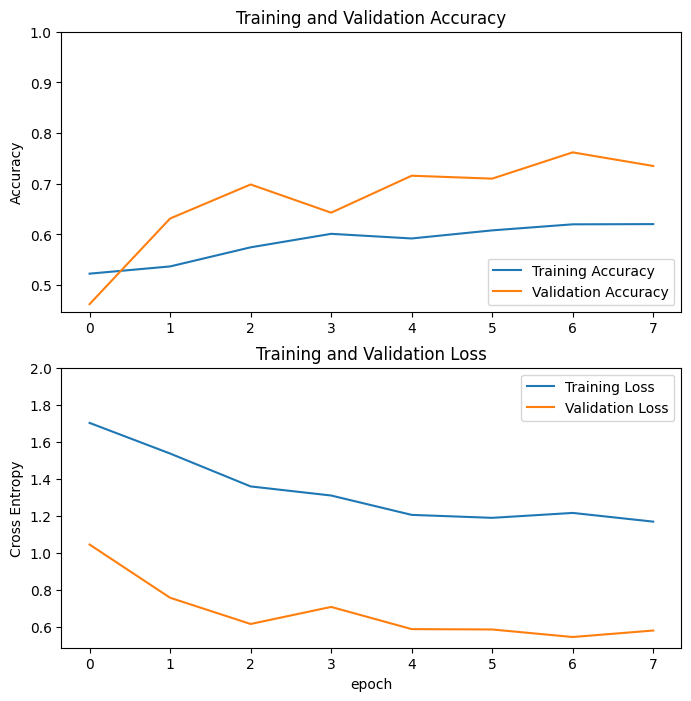

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()),2])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [ ]:
#Load the best model during initial training
model.load_weights(ckpt_filename)


Fine Tuning

In [ ]:
#Finetuning - Unfreeze the last layers of the model
model.summary()
base_model.trainable = True


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1/conv (Conv2D)            (None, None, None,   9408        ['zero_padding2d[0][0]']         
                                64)                                                           

In [ ]:
#compile model
model.compile(optimizer= Adam(lr=base_learning_rate/10), loss= "binary_crossentropy", metrics = ['accuracy'])

# Callbacks
final_ckpt_filename= "/content/drive/My Drive/DATASET/chest_xray/dn121_class_weights_pretrained.hdf5"
checkpoint = ModelCheckpoint(filepath=final_ckpt_filename, save_best_only=True, save_weights_only=True, verbose = 1)

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, mode='min', verbose = 1)



In [ ]:

fine_tune_epochs = 4

# Fitting the model
history_unfreeze = model.fit(train_gen,
                    epochs= fine_tune_epochs,
                    validation_data=val_gen,
                    callbacks=[checkpoint, early_stop, lr_reduce],
                    class_weight = {0: class_weights[0], 1: class_weights[1]})


Epoch 1/4
147/147 [==============================] - ETA: 0s - loss: 0.4407 - accuracy: 0.8833 
Epoch 1: val_loss improved from inf to 0.17727, saving model to /content/drive/My Drive/DATASET/chest_xray/dn121_class_weights_pretrained.hdf5
147/147 [==============================] - 4350s 29s/step - loss: 0.4407 - accuracy: 0.8833 - val_loss: 0.1773 - val_accuracy: 0.9251 - lr: 1.0000e-05
Epoch 2/4
147/147 [==============================] - ETA: 0s - loss: 0.1264 - accuracy: 0.9521 
Epoch 2: val_loss improved from 0.17727 to 0.15022, saving model to /content/drive/My Drive/DATASET/chest_xray/dn121_class_weights_pretrained.hdf5
147/147 [==============================] - 4279s 29s/step - loss: 0.1264 - accuracy: 0.9521 - val_loss: 0.1502 - val_accuracy: 0.9328 - lr: 1.0000e-05
Epoch 3/4
 14/147 [=>............................] - ETA: 1:02:15 - loss: 0.0973 - accuracy: 0.9665

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-11bf514cc261>", line 4, in <cell line: 4>
    history_unfreeze = model.fit(train_gen,
  File "/usr/local/lib/python3.9/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.9/dist-packages/keras/engine/training.py", line 1685, in fit
    tmp_logs = self.train_function(iterator)
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py", line 894, in __call__
    result = self._call(*args, **kwds)
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/polymorphic_function/

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-11bf514cc261>", line 4, in <cell line: 4>
    history_unfreeze = model.fit(train_gen,
  File "/usr/local/lib/python3.9/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.9/dist-packages/keras/engine/training.py", line 1685, in fit
    tmp_logs = self.train_function(iterator)
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py", line 894, in __call__
    result = self._call(*args, **kwds)
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/polymorphic_function/

TypeError: ignored

In [ ]:
acc = history_unfreeze.history['accuracy']
val_acc = history_unfreeze.history['val_accuracy']

loss = history_unfreeze.history['loss']
val_loss = history_unfreeze.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy after unfreezing all layers')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss after unfreezing all layers')
plt.xlabel('epoch')
plt.show()

NameError: ignored

In [ ]:
model.summary()

NameError: ignored

In [ ]:

#Evaluate on the test data
test_loss, test_score = model.evaluate(test_gen)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)


In [ ]:
def fn_preprocess_images(data_directory, image_size):
  bacteria_pneumonia_dir = os.path.join(data_directory, 'NORMAL')
  virus_pneumonia_dir = os.path.join(data_directory, 'PNEUMONIA')

  # Get the list of all the images
  bacteria_cases = glob(bacteria_pneumonia_dir + '/*.jpeg')
  virus_cases = glob(virus_pneumonia_dir + '/*.jpeg')

  #Store all images and labels
  image_data_list = []
  labels = []

  for img_path in bacteria_cases:
    img = image.load_img(img_path, target_size=(image_size, image_size))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    #print('Input image shape:', x.shape)
    image_data_list.append(x)
    labels.append(0)

  for img_path in virus_cases:
    img = image.load_img(img_path, target_size=(image_size, image_size))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    #print('Input image shape:', x.shape)
    image_data_list.append(x)
    labels.append(1)

  #Convert the images to tensor shape (n_images, h, w, channel)
  img_data = np.array(image_data_list)
  img_data=np.rollaxis(img_data,1,0)
  img_data=img_data[0]
  print("Final data shape: "+str(img_data.shape))

  #convert label list to numpy array
  labels = np.array(labels)

  return img_data,labels



In [ ]:
test_data, test_labels  = fn_preprocess_images(test_data_path, image_size = 224)


#Predict on test data
preds = model.predict(test_data)


# Classification report
from sklearn.metrics import accuracy_score,classification_report, roc_curve, confusion_matrix

acc = accuracy_score(test_labels, np.round(preds))*100
print("Test data accuracy : "+str(acc))
print("Classification report")
print(classification_report(test_labels,np.round(preds)))


In [ ]:

#Plot the confusion matrix
from sklearn.metrics import accuracy_score,classification_report, roc_curve, confusion_matrix

test_data, test_labels  = fn_preprocess_images(test_data_path, image_size = 224)

conf_matrix = confusion_matrix(test_labels, np.round(preds))
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix,
            annot=True,
            xticklabels=['Bacteria Pneumonia', 'Virus Pneumonia'],
            yticklabels=['Bacteria Pneumonia', 'Virus Pneumonia'],
            cmap="Blues",
            fmt='g')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.show()


ROC Curve

In [ ]:
from sklearn.metrics import roc_curve, auc

preds = model.predict(test_data)

test_data, test_labels  = fn_preprocess_images(test_data_path, image_size = 224)


y_preds = preds.ravel()
model_fpr, model_tpr, model_threshold = roc_curve(test_labels, y_preds)
model_auc = auc(model_fpr, model_tpr)


plt.plot([0, 1], [0, 1], 'k--')
plt.plot(model_fpr, model_tpr, label='AUC Score(area = {:.3f})'.format(model_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('DenseNet 121 using class weights - ROC curve ')
plt.legend(loc='best')
plt.show()


GRAD-CAM

In [ ]:
!pip install tensorflow

In [ ]:
import os
import numpy as np
import pandas as pd
import random
import cv2
import seaborn as sns
from PIL import Image
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sns
import argparse
import imutils
import tensorflow as tf
import pandas.util.testing as tm
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img,img_to_array #,ImageDataGenerator
from keras.layers import Dense, GlobalAveragePooling2D, Input, Flatten, Dropout, BatchNormalization
from keras.models import Model, Sequential
from keras import backend as K
from keras.applications.densenet import DenseNet121
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing import image
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

import os
import re
import cv2
import numpy as np
import seaborn as sns
!pip install imutils
import imutils
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from IPython.display import Image
import matplotlib.cm as cm
from tqdm import tqdm
import matplotlib.pyplot as plt
barsize = '{l_bar}{bar:10}{r_bar}{bar:-10b}'



In [ ]:
#Get all the images
test_data_path = '/content/drive/MyDrive/chest_xrays/test'
# Get few samples for both the classes
bacteria_cases_dir = os.path.join(test_data_path,'NORMAL/')
virus_cases_dir = os.path.join(test_data_path,'PNEUMONIA/')

# Get the list of all the images
bacteria_cases = glob(bacteria_cases_dir + '*.jpeg')
virus_cases = glob(virus_cases_dir + '*.jpeg')

samples = []

# Go through all the bacteria cases. The label for these cases will be 0
for i in bacteria_cases:
    samples.append(i)

# Go through all the virus cases. The label for these cases will be 1
for i in virus_cases:
    samples.append(i)

In [ ]:
import numpy as np
import pandas as pd
import cv2
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [ ]:
def plot_history(history, desc = ''):

    fig = plt.figure(figsize = (18 , 6))

    if desc:
        plt.title('{}'.format(desc), fontsize = 16, y = -0.1)

    subplot = (1, 2, 1)
    fig.add_subplot(*subplot)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['train loss', 'valid loss'])
    plt.grid(True)
    plt.plot()

    subplot = (1, 2, 2)
    fig.add_subplot(*subplot)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['train acc', 'valid acc'])
    plt.grid(True)
    plt.plot()

def crop_brain_contour(image, plot=False):

    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    return new_image

In [ ]:
IMGS = 256
main = '/content/drive/MyDrive/chest_xray'

In [ ]:
categ = ['test', 'train', 'val']
classes = ['PNEUMONIA','NORMAL']
images = []
labels = []
# x_test = []
# y_test = []
# x_valid = []
# x_valid = []
for i in categ:
    sub_path = os.path.join(main, i)
    for j  in classes:
        path = os.path.join(sub_path, j)
        temp = os.listdir(path)
        for x in temp:
            addr = os.path.join(path, x)
            img_arr = cv2.imread(addr)
            img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY)
            img_arr = crop_brain_contour(img_arr, False)
            img_arr = cv2.resize(img_arr, (IMGS, IMGS))
            images.append(img_arr)
            if j == 'PNEUMONIA':
                l = 1
            else:
                l = 0
            labels.append(l)

images = np.array(images)
labels = np.array(labels)
print(images.shape, labels.shape)

In [ ]:
from sklearn.model_selection import train_test_split as tts
x_train, x_test, y_train, y_test = tts(images, labels, random_state = 42, test_size = .30)
x_valid, x_test, y_valid, y_test = tts(x_test, y_test, random_state = 42, test_size = .50)

In [ ]:
fig = plt.figure(figsize = (12, 4))
plt.grid(True)
plt.axis(False)

fig.add_subplot(1, 4, 1)
sns.countplot(labels, palette = 'autumn')
plt.xlabel('All')

fig.add_subplot(1, 4, 2)
sns.countplot(y_train, palette = 'autumn')
plt.xlabel('train')

fig.add_subplot(1, 4, 3)
sns.countplot(y_test, palette = 'autumn')
plt.xlabel('test')

fig.add_subplot(1, 4, 4)
sns.countplot(y_valid, palette = 'autumn')
plt.xlabel('val')

plt.show()


In [ ]:
x_train = x_train.reshape(-1, IMGS, IMGS, 3)
x_valid = x_valid.reshape(-1, IMGS, IMGS, 3)
x_test = x_test.reshape(-1, IMGS, IMGS, 3)

In [ ]:
fig = plt.figure(figsize = (16,7))
z = np.random.randint(1, 5000, 11)
rows = 2
columns = 5
for i in range(1, rows*columns+1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(images[z[i]])
    plt.title(classes[labels[z[i]]])
    plt.axis(False)
plt.show()

In [ ]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_valid.shape, y_valid.shape)

In [ ]:
class my_callbacks(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if (logs.get('val_accuracy') > .95):
            print("Accuracy is High Enough so Stopping Training")
            self.model.stop_training= True

In [ ]:
base_model = tf.keras.applications.VGG16(weights = 'imagenet',
                                            include_top = False,
                                            input_shape = (IMGS, IMGS, 3))

last = base_model.get_layer('block3_pool').output
x = layers.GlobalAveragePooling2D()(last)
x = layers.Dense(256, activation = 'relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation = 'relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(32, activation = 'relu')(x)
pred = layers.Dense(1, activation = 'sigmoid')(x)

In [ ]:
import keras
from tensorflow.keras import Model
#model = keras.engine.Model(base_model.input, pred)
model.compile(loss='binary_crossentropy',optimizer = tf.keras.optimizers.Adam(lr=0.0001),metrics=['accuracy'])

In [ ]:
callback = my_callbacks()
history = model.fit(x_train, y_train, epochs = 20, batch_size = 32, validation_data = (x_valid, y_valid), callbacks = [callback])

In [ ]:
plot_history(history)

In [ ]:
model.evaluate(x_test, y_test)

In [ ]:
from skimage import io

#img_arr = io.imread('/content/drive/MyDrive/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg')
img_arr = cv2.imread('/content/drive/MyDrive/chest_xray/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg')
img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY)
classes = ['NORMAL','PNEUMONIA']
img_arr = crop_brain_contour(img_arr, False)
img_arr = cv2.resize(img_arr, (IMGS, IMGS))
plt.imshow(img_arr)
plt.show()
img_arr = img_arr.reshape(1, IMGS, IMGS, 3)
print(classes[int(np.round(model.predict(img_arr)[0][0]))])

In [ ]:
lay = []
for layer in model.layers:
    lay.append(layer.name)
    print(layer.name)

In [ ]:
model_builder = model
img_size = (IMGS, IMGS)
def preprocess_input(img):
    img_arr = cv2.imread(img)
    img_arr = crop_brain_contour(img_arr, False)
    img_arr = cv2.resize(img_arr, img_size)
    img_arr = img_arr.reshape(IMGS, IMGS, 3)
    return img_arr

def decode_prediction(prediction):
    return classes[int(prediction[0])]

last_conv_layer_name = lay[9]

classifier_layer_names = lay[10:]

img_path = '/content/drive/MyDrive/chest_xray/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg'

plt.imshow(preprocess_input(img_path))
plt.show()

In [ ]:


def get_img_array(img_path, size):
    img_arr = cv2.imread(img_path)
    img_arr = crop_brain_contour(img_arr, False)
    img_arr = cv2.resize(img_arr, (256, 256))
    img_arr = img_arr.reshape(1, 256, 256, 3)
    return img_arr

In [ ]:
#!pip install tensorflow
import keras.utils as image
#from keras.preprocessing.image import img_to_array

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = tf.keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tf.keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:

img_array = get_img_array(img_path, size = img_size)

# Make model
#model = model_builder(weights="imagenet")

# Remove last layer's softmax
#model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", classes[int(np.round(model.predict(img_arr)[0][0]))])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

In [ ]:
output1=classes[int(np.round(model.predict(img_arr)[0][0]))]
output2=heatmap

In [ ]:
from keras.models import load_model
model.save('/content/drive/MyDrive/chest_xray/new_model.hdf5')
new_model = load_model('/content/drive/MyDrive/chest_xray/new_model.hdf5')

In [ ]:
# Load the original image
img = tf.keras.utils.load_img(img_path)
img = tf.keras.utils.img_to_array(img)

# Rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# Use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# Use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# Resize heatmap to match the size of the input image
jet_heatmap = tf.image.resize(jet_heatmap, (img.shape[0], img.shape[1]))

# Create an image with RGB colorized heatmap
jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = tf.keras.utils.array_to_img(superimposed_img)

# Save and display Grad CAM
save_path = "grad_cam.jpg"
superimposed_img.save(save_path)
print("Predicted:", classes[int(np.round(model.predict(img_array)[0]))])
plt.imshow(superimposed_img)


In [ ]:
output3=superimposed_img

In [ ]:
y_pred = model.predict(x_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(np.round(y_pred),y_test))

In [ ]:
y_pred = np.round(y_pred)
y_pred = y_pred.reshape(-1,)
y_test = y_test.astype('float')
y_test.shape

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
print('''[‘True Neg’,’False Pos’
,’False Neg’,’True Pos’]''')
plt.show()

In [ ]:
from keras.models import load_model
model.save('/content/drive/MyDrive/chest_xray/new_model.hdf5')
new_model = load_model('/content/drive/MyDrive/chest_xray/new_model.hdf5')

In [ ]:
new_model = load_model('/content/drive/MyDrive/chest_xray/new_model.hdf5')

In [ ]:
new_model.evaluate(x_test, y_test)

In [ ]:
new_model.summary()

In [ ]:
from keras.models import load_model
model.save('/content/drive/MyDrive/chest_xray/new_model.hdf5')
new_model = load_model('/content/drive/MyDrive/chest_xray/new_model.hdf5')